### The study will help identify optimal locations for a cafe in North York, given existing attractions and rent.

### 1. Import modules

In [1]:
#importing libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
import warnings
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup as bs

In [2]:
#importing new libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

### 2. Parsing the HTML

In [3]:
from urllib.request import urlopen
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

### 3. Extract data and make it into DF

In [4]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

In [5]:
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

In [6]:
data = get_row()
columns = ['Postcode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(data, columns=columns)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### 4. Clean data

In [7]:
#ignore cells with no assigned borough
df1 = df[df.Borough != 'Not assigned']
df1 = df1.sort_values(by=['Postcode','Borough'])

df1.reset_index(inplace=True)
df1.drop('index',axis=1,inplace=True)

df1.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df_postcodes = df1['Postcode']
df_postcodes.drop_duplicates(inplace=True)
df2 = pd.DataFrame(df_postcodes)
df2['Borough'] = '';
df2['Neighbourhood'] = '';


df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)

#if more than one neighborhood
for i in df2.index:
    for j in df1.index:
        if df2.iloc[i, 0] == df1.iloc[j, 0]:
            df2.iloc[i, 1] = df1.iloc[j, 1]
            df2.iloc[i, 2] = df2.iloc[i, 2] + ',' + df1.iloc[j, 2]
            
for i in df2.index:
    s = df2.iloc[i, 2]
    if s[0] == ',':
        s =s [1:]
    df2.iloc[i,2 ] = s

In [9]:
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
!pip install geocoder
!pip install folium

import geocoder

     |████████████████████████████████| 102kB 8.9MB/s ta 0:00:011


In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

In [12]:
# Retrieving Postal Code Co-ordinates
postcode = df2['Postcode']    
coords = [ get_latilong(postcode) for postcode in postcode.tolist() ]

In [13]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df2['Latitude'] = df_coords['Latitude']
df2['Longitude'] = df_coords['Longitude']
df2.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944


In [21]:
#create new df for Scarborough
df_dt = df2.copy()
df_dt = df_dt[df2.Borough.str.contains("North York")]
df_dt

,Postcode,Borough,Neighbourhood,Latitude,Longitude
17,M2H,North York,Hillcrest Village,43.80285,-79.35621
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781
19,M2K,North York,Bayview Village,43.78102,-79.38060
20,M2L,North York,"York Mills, Silver Hills",43.75722,-79.37974
21,M2M,North York,"Willowdale, Newtonbrook",43.79135,-79.41356
22,M2N,North York,"Willowdale, Willowdale East",43.76714,-79.40707
23,M2P,North York,York Mills West,43.74787,-79.40029
24,M2R,North York,"Willowdale, Willowdale West",43.77991,-79.44678
25,M3A,North York,Parkwoods,43.75188,-79.33036
26,M3B,North York,Don Mills,43.74929,-79.36169


### 5. Map of North York

In [22]:
CLIENT_ID = 'ALBUZU4P4YSINSSQTSG2CH4VYFRELVFL0ZSFKYICCJ0BZ5BG'
CLIENT_SECRET = 'DYP2YJDFWZUBDSHQRTTBFQ3HADGYPWFRIAGTL3AZZ2N3OTAI'
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: ALBUZU4P4YSINSSQTSG2CH4VYFRELVFL0ZSFKYICCJ0BZ5BG
CLIENT_SECRET: DYP2YJDFWZUBDSHQRTTBFQ3HADGYPWFRIAGTL3AZZ2N3OTAI


In [23]:
toronto_map = folium.Map(location = [43.65, -79.4], zoom_start = 12)

for latitude, longitude, borough, neighbourhood in zip(df_dt['Latitude'], df_dt['Longitude'], df_dt['Borough'], df_dt['Neighbourhood']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color= '#3186cc',
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map

In [24]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [25]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups'],
      dtype='object')

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 6. Categorize Nearby Locations

In [27]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Panino Cappuccino,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.738389,-79.539347
1,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.733757,-79.536615
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.734998,-79.533813
3,Las Brisas Del Mar,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",43.736365,-79.534895
4,Joseph Bannon Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.732760,-79.532351


In [28]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Panino Cappuccino,Café,43.738389,-79.539347
1,Tim Hortons,Coffee Shop,43.733757,-79.536615
2,Tim Hortons,Coffee Shop,43.734998,-79.533813
3,Las Brisas Del Mar,Nightclub,43.736365,-79.534895
4,Joseph Bannon Park,Park,43.732760,-79.532351


In [29]:
#check top 5 categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:5]

Coffee Shop                  2
Park                         1
Café                         1
Latin American Restaurant    1
Nightclub                    1
Name: categories, dtype: int64

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:

DT_venues = getNearbyVenues(names=df_dt['Neighbourhood'],
                                   latitudes=df_dt['Latitude'],
                                   longitudes=df_dt['Longitude']
                                  )

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Bedford Park, Lawrence Manor East
Lawrence Manor, Lawrence Heights
Glencairn
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Humberlea, Emery


In [32]:
print('There are {} Uniques Categories.'.format(len(DT_venues['Venue Category'].unique())))
DT_venues.groupby('Neighborhood').count().head()

There are 129 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27
Don Mills,50,50,50,50,50,50
Downsview,44,44,44,44,44,44


### Using One Hot Encoding

In [33]:
# one hot encoding
DT_onehot = pd.get_dummies(DT_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DT_onehot['Neighborhood'] = DT_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DT_onehot.columns[-1]] + list(DT_onehot.columns[:-1])
DT_onehot = DT_onehot[fixed_columns]
DT_grouped = DT_onehot.groupby('Neighborhood').mean().reset_index()
DT_onehot.head(5)

,Neighborhood,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Store,Bike Shop,Bookstore,Boutique,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Music Store,Nightclub,Optical Shop,Other Great Outdoors,Park,Pet Store,Pharmacy,Photography Lab,Pizza Place,Platform,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Soccer Field,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio
0,Hillcrest Village,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
num_top_venues = 5
for hood in DT_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =DT_grouped[DT_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1     Convenience Store  0.25
2  Other Great Outdoors  0.25
3               Airport  0.00
4    Miscellaneous Shop  0.00


---- Bayview Village ----
               venue  freq
0               Park  0.33
1   Asian Restaurant  0.33
2              Trail  0.33
3       Optical Shop  0.00
4  Mobile Phone Shop  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.07
1         Coffee Shop  0.07
2      Sandwich Place  0.07
3          Restaurant  0.07
4         Pizza Place  0.07


---- Don Mills ----
                 venue  freq
0          Coffee Shop  0.10
1  Japanese Restaurant  0.06
2           Restaurant  0.06
3                  Gym  0.04
4          Supermarket  0.04


---- Downsview ----
           venue  freq
0    Coffee Shop  0.09
1           Park  0.07
2    Pizza Place  0.07
3  Grocery Store  0.07
4          Hotel  0.05




In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common Venues in North York

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DT_grouped['Neighborhood']

for ind in np.arange(DT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Yoga Studio,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store
1,Bayview Village,Asian Restaurant,Trail,Park,Yoga Studio,Falafel Restaurant,French Restaurant,Food Court,Food & Drink Shop,Fish Market,Fast Food Restaurant
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Pizza Place,Restaurant,Coffee Shop,Comfort Food Restaurant,Sports Club,Café,Liquor Store,Butcher
3,Don Mills,Coffee Shop,Japanese Restaurant,Restaurant,Italian Restaurant,Bank,Dim Sum Restaurant,Shopping Mall,Beer Store,Supermarket,Gym
4,Downsview,Coffee Shop,Pizza Place,Park,Grocery Store,Hotel,Discount Store,Moving Target,Mobile Phone Shop,Fast Food Restaurant,Vietnamese Restaurant
5,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Juice Bar,Bank,Japanese Restaurant,Women's Store,Cosmetics Shop,Sandwich Place
6,Glencairn,Pizza Place,Grocery Store,Sushi Restaurant,Ice Cream Shop,Pub,Fast Food Restaurant,Fish Market,Mediterranean Restaurant,Gas Station,Latin American Restaurant
7,Hillcrest Village,Park,Pharmacy,Bakery,Chinese Restaurant,Residential Building (Apartment / Condo),Diner,Discount Store,Dim Sum Restaurant,Fried Chicken Joint,Electronics Store
8,Humber Summit,Furniture / Home Store,Arts & Crafts Store,Bakery,Electronics Store,Fish Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop
9,"Humberlea, Emery",Coffee Shop,Nightclub,Park,Discount Store,Café,Latin American Restaurant,Fast Food Restaurant,Food Court,Food & Drink Shop,Fish Market


### K-Means Clustering Approach

In [37]:
# Cluster neighborhood into 3 clusters
DT_grouped_clustering = DT_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(DT_grouped_clustering)
kmeans.labels_

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2],
      dtype=int32)

In [38]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

DT_merged =df_dt.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DT_merged = DT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

DT_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.80285,-79.35621,1,Park,Pharmacy,Bakery,Chinese Restaurant,Residential Building (Apartment / Condo),Diner,Discount Store,Dim Sum Restaurant,Fried Chicken Joint,Electronics Store
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Juice Bar,Bank,Japanese Restaurant,Women's Store,Cosmetics Shop,Sandwich Place
19,M2K,North York,Bayview Village,43.78102,-79.38060,1,Asian Restaurant,Trail,Park,Yoga Studio,Falafel Restaurant,French Restaurant,Food Court,Food & Drink Shop,Fish Market,Fast Food Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.75722,-79.37974,2,Park,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant
21,M2M,North York,"Willowdale, Newtonbrook",43.79135,-79.41356,0,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Pizza Place,Hookah Bar,Beer Store,Diner,Ramen Restaurant,Sake Bar
22,M2N,North York,"Willowdale, Willowdale East",43.76714,-79.40707,0,Coffee Shop,Pizza Place,Fast Food Restaurant,Sandwich Place,Ramen Restaurant,Japanese Restaurant,Grocery Store,Restaurant,Fried Chicken Joint,Bank
23,M2P,North York,York Mills West,43.74787,-79.40029,0,Coffee Shop,Restaurant,Food Court,French Restaurant,Convenience Store,Optical Shop,Sandwich Place,Business Service,Bus Station,Metro Station
24,M2R,North York,"Willowdale, Willowdale West",43.77991,-79.44678,0,Pizza Place,Pharmacy,Park,Coffee Shop,Bank,Grocery Store,Falafel Restaurant,Food Court,Food & Drink Shop,Fish Market
25,M3A,North York,Parkwoods,43.75188,-79.33036,1,Park,Construction & Landscaping,Pet Store,Food & Drink Shop,Bed & Breakfast,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Court,Fish Market
26,M3B,North York,Don Mills,43.74929,-79.36169,0,Coffee Shop,Japanese Restaurant,Restaurant,Italian Restaurant,Bank,Dim Sum Restaurant,Shopping Mall,Beer Store,Supermarket,Gym


### Create map of clusters

In [39]:
kclusters = 2

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(DT_merged['Latitude'], 
                                   DT_merged['Longitude'], 
                                   DT_merged['Neighbourhood'], 
                                   DT_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#ff0000']


In [40]:
dfone=DT_merged.loc[DT_merged['Cluster Labels'] == 0,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]
dftwo=DT_merged.loc[DT_merged['Cluster Labels'] == 1,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]
dfthree=DT_merged.loc[DT_merged['Cluster Labels'] == 2,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]

In [45]:
DT_Avg_RentPrice=pd.DataFrame({"Neighborhood":df_dt["Neighbourhood"],
                                      "Average_Rent_Price":[573900.0,533500.0,279200.0,533500.0,279200.0,433500.0,335000.0,286600.0,
                                                               375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               533500.0,279200.0,573900.0, 425000.0, 255400.0,493500.0]})

In [46]:
DT_Avg_RentPrice.set_index('Neighborhood',inplace=True,drop=True)

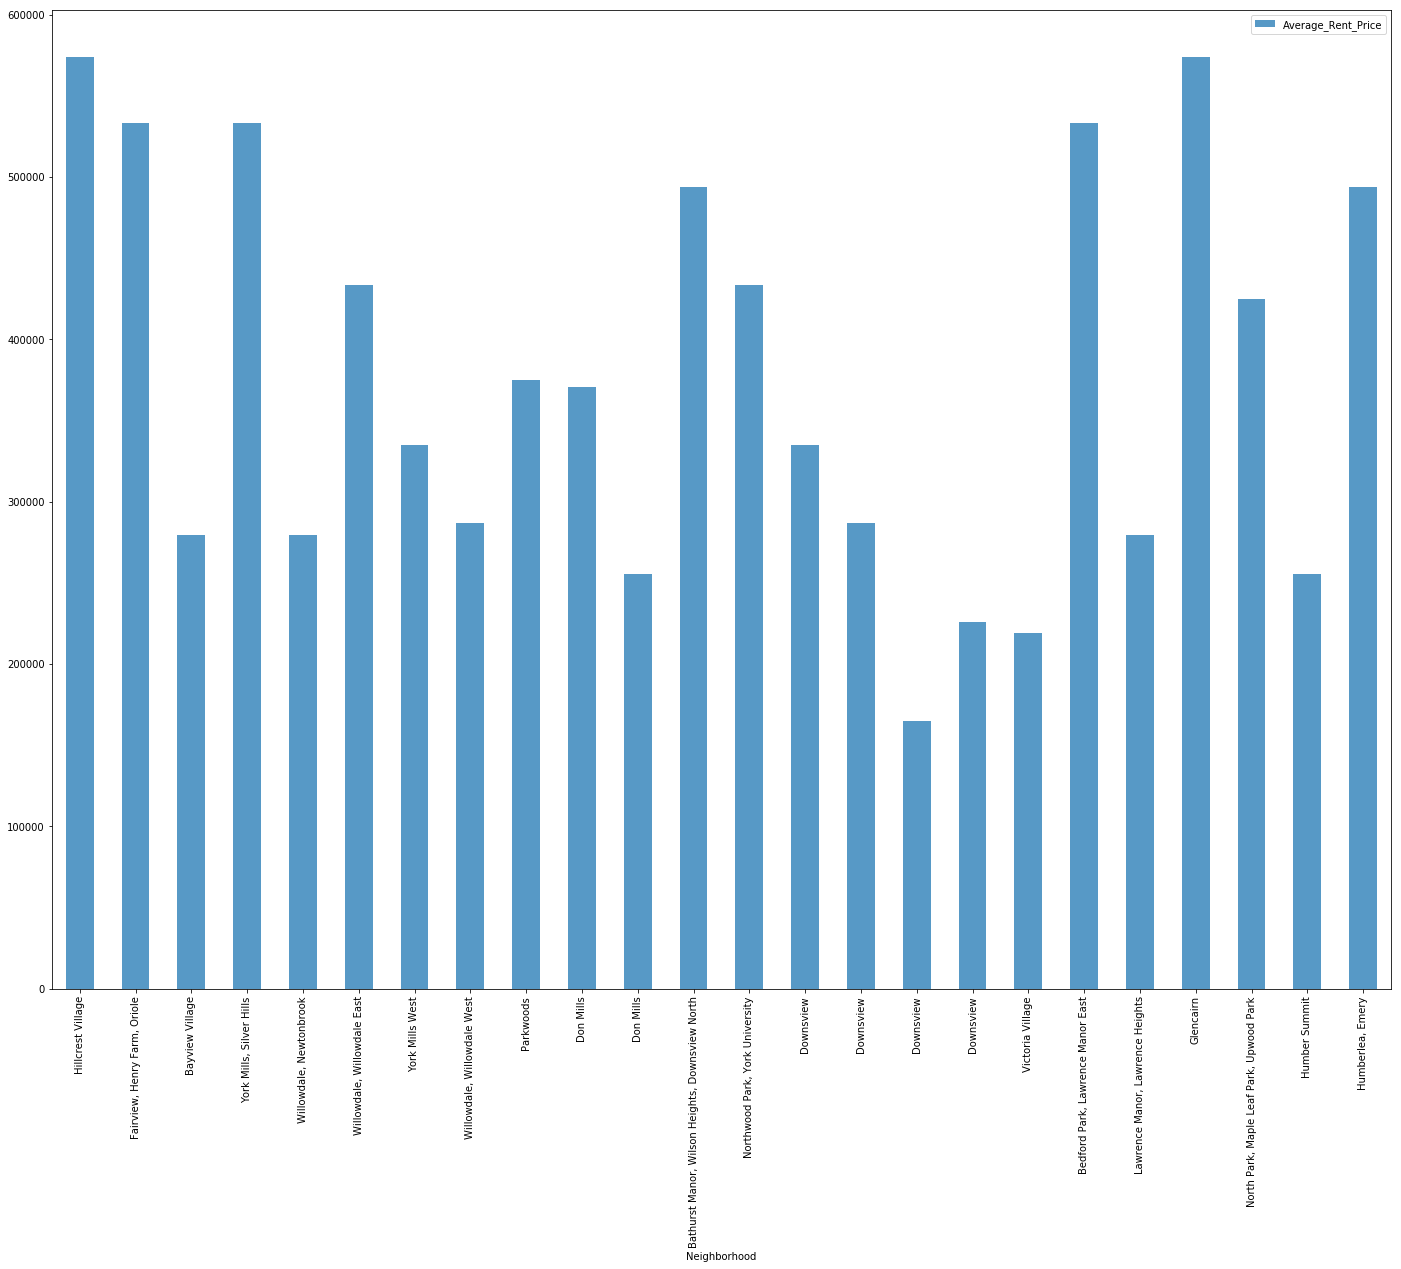

In [47]:

DT_Avg_RentPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)